In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Mental disorders analysis

## Introduction

## Data Cleanup

Let's begin with the Student Depression Dataset.csv dataset.

In [201]:
data = pd.read_csv('data/Student Depression Dataset.csv')

In [220]:
data

,id,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,5-6 hours,Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,7-8 hours,Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,0,27.0,Surat,5.0,5.75,5.0,5-6 hours,Unhealthy,Class 12,1,7.0,1.0,1,0
27897,140686,1,27.0,Ludhiana,2.0,9.40,3.0,Less than 5 hours,Healthy,MSc,0,0.0,3.0,1,0
27898,140689,1,31.0,Faridabad,3.0,6.61,4.0,5-6 hours,Unhealthy,MD,0,12.0,2.0,0,0
27899,140690,0,18.0,Ludhiana,5.0,6.88,2.0,Less than 5 hours,Healthy,Class 12,1,10.0,5.0,0,1


First thing we notice is that the dataset contains a column named Profession. However, that column includes Student as a value. We also have Work/Study Hours.

In [203]:
profession_stats = data["Profession"].value_counts().reset_index()
profession_stats.columns = ["Profession", "Count"]
profession_stats

,Profession,Count
0,Student,27870
1,Architect,8
2,Teacher,6
3,Digital Marketer,3
4,Chef,2
5,Content Writer,2
6,Pharmacist,2
7,Doctor,2
8,UX/UI Designer,1
9,Civil Engineer,1


The histogram says it all :)

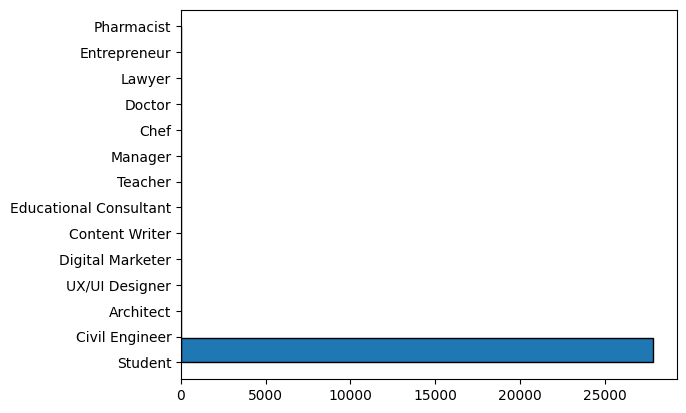

In [204]:
plt.hist(data["Profession"], bins=len(profession_stats), edgecolor='black', orientation='horizontal')
plt.show()

As the name of the dataset suggests, it is about student. Data also shows it by having too little of the ramaining values. That is why I am going to assume that any other profession is not usable for any hypothesis and any row that is not a student will be considered to be an outlier and therefore be removed.

In [205]:
data = data[data["Profession"] == "Student"]

Let's not forget to rename the Work/Study Hours since it would not make sense otherwise

In [206]:
data = data.rename(columns={"Work/Study Hours": "Study Hours"})

We can also see that there are very few students that have a value for the column Job Satisfaction. However, the profession is Student. These students could either be studying and working or only studying but since the value in the previously named column Work/Job Hours was in one place, I will assume that this data is redundant and could be deleted.

In [207]:
data["Job Satisfaction"].value_counts()

Job Satisfaction
0.0    27862
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [208]:
data = data[data["Job Satisfaction"] == 0]
data = data.drop(columns=["Job Satisfaction"])

Here we can see that there are diferent values for Work Pressure and since we already decided to test only for students that are not employed, I am going to drop those that are equal to 0

In [209]:
data["Work Pressure"].value_counts()

Work Pressure
0.0    27862
Name: count, dtype: int64

In [210]:
data = data.drop(columns=["Work Pressure"])

Since we removed all records where the Profession column has a value diferrent than Student we can remove the whole column since it does not bring any new knowledge

In [211]:
data = data.drop(columns=["Profession"])

Now in order to be more consistent I will translate the values of the folowing columns to 0 and 1 instead of Yes or No:

Have you ever had suicidal thoughts ?
Family History of Mental Illness

And the gender column to:

Male = 0 and Female = 1

But let's first see if there are values that are not Yes or No and Male or Female

In [212]:
print(data["Have you ever had suicidal thoughts ?"].value_counts())
print(data["Family History of Mental Illness"].value_counts())
print(data["Gender"].value_counts())  

Have you ever had suicidal thoughts ?
Yes    17626
No     10236
Name: count, dtype: int64
Family History of Mental Illness
No     14378
Yes    13484
Name: count, dtype: int64
Gender
Male      15523
Female    12339
Name: count, dtype: int64


In [213]:
data["Have you ever had suicidal thoughts ?"] = (data["Have you ever had suicidal thoughts ?"] == "Yes").astype(int)
data["Family History of Mental Illness"] = (data["Family History of Mental Illness"] == "Yes").astype(int)
data["Gender"] = (data["Gender"] == "Male").astype(int)

In [214]:
data

,id,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,5-6 hours,Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,7-8 hours,Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,0,27.0,Surat,5.0,5.75,5.0,5-6 hours,Unhealthy,Class 12,1,7.0,1.0,1,0
27897,140686,1,27.0,Ludhiana,2.0,9.40,3.0,Less than 5 hours,Healthy,MSc,0,0.0,3.0,1,0
27898,140689,1,31.0,Faridabad,3.0,6.61,4.0,5-6 hours,Unhealthy,MD,0,12.0,2.0,0,0
27899,140690,0,18.0,Ludhiana,5.0,6.88,2.0,Less than 5 hours,Healthy,Class 12,1,10.0,5.0,0,1


## Some hypothesis

### Hypothesis 01

### Hypothesis 02

### Hypothesis 03

### Hypothesis ...

### Hypothesis N

## Some more serious data science (Regression maybe)

## Sources

[Student Depression Dataset.](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

[Depression Dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset)

[Social Anxiety Dataset](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data)

[Anxiety and Depression Mental Health Factors](https://www.kaggle.com/datasets/ak0212/anxiety-and-depression-mental-health-factors)

[OCD Patient Dataset: Demographics & Clinical Data](https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data)

[OCD_Social_Media_Dataset](https://www.kaggle.com/datasets/bhagvendersingh/ocd-social-media-dataset)

[Mental Disorders Dataset](https://www.kaggle.com/datasets/baselbakeer/mental-disorders-dataset/data)